# Pressure Test

## Status

#### Testing for within 1 smoothing length
* Tested two particles, and they move apart, regardless of their starting position
* Tested 4 particles in the following configurations, and they move apart
    * 3 colinear, and 1 off axis
    * Square
* Tested 5 paricles, in the following configurations, and they move apart
    * Square, with one extra particle in the middle
    * Square, with one particle slightly off center
        * The particle stays put for a while, but then accelerates suspiciously quickly
* dt is unreasonably large right now

#### Testing for within 2 smoothing lengths

#### Visualizing the acceleration
* Haven't done it yet, but color the particles with their acc

## Next step
* Test more particles

#### Did that
* Results: Do not take a dot product to get gradP

## Notes
* W1 inside of gradW is returning a 3D array. It should be returning a 2D array.
* Within distVect, there is one entry in each row which is the distance between the particle and itself (ie: 0)
* Some distVect returns a boolean, sometimes a 1 or a 0

### Imports

In [52]:
%pylab inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb

Populating the interactive namespace from numpy and matplotlib


### Constants

In [53]:
dt = 1e7
stepN = 50

### Initialize position, velocity, mass, pressure, density, and time

In [54]:
xyDistribution = [
                 [1000.0, 1000.0],
                 [-1000.0, -1000.0]
#                 [-1000.0, -1000.0],
#                 [-1000.0, 1000.0],
#                 [10.0, 0.0]
                 ]

xyDistribution=np.array(xyDistribution)

# nParticles = 50
# xyDistribution = np.random.normal(0,100, size=(nParticles, 2))
nParticles = len(xyDistribution)

velocityDistribution = np.zeros_like(xyDistribution, dtype = np.float)

mDistribution = np.ones(nParticles, dtype=float) * 100000000.0

# Pressure and density based off of what we're seeing in Jupiter
pressureDistribution = np.ones(nParticles, dtype=float) * 4e13
rhoDistribution = np.ones(nParticles, dtype=float) * 3

ParticlePositionHistory = np.zeros((nParticles,2,stepN))
ParticleVelocityHistory = np.zeros((nParticles, 2, stepN))

timeArray = np.zeros(stepN)
for i in range(stepN):
    timeArray[i] = i*dt

[]

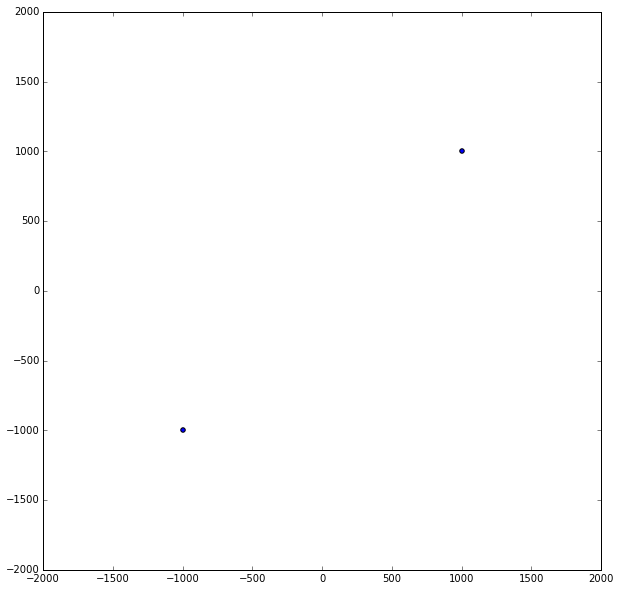

In [55]:
plt.figure(figsize=(10,10))
plt.scatter(xyDistribution[:,0], xyDistribution[:,1], c='b')
plt.xlim(-2000, 2000)
plt.ylim(-2000, 2000)
plt.plot()

### Define smoothing gradient

In [64]:
def gradW(xyDistribution, h= 2e3, verbose=False):
    '''
    TESTS
    Are we doing this in cartesian or polar?
        Cartesian works
    h = ~3e9 looks like a good range
    Finding W for all pairs (i,j), instead of just j. 
    I'm flattening W at the end of the function. I might be meant to flatten W
        by flattening the |r-rj| by taking their sum
    Should I be inputting abs(X) or just X? What is X relative to?
    Might need to do final summation wrt axis 2, not axis1
    '''
    distVect = np.zeros((len(xyDistribution), len(xyDistribution)))
    thetaVect = np.zeros_like(distVect)
    X = np.zeros_like(distVect)
    Y = np.zeros_like(distVect)
                  
    # Find distance between each j and the other points
    for i in range(len(xyDistribution)):
        particle_i = xyDistribution[i]
        
        # Sloppy right now. Can save save computing power later.
        dist = np.sqrt((particle_i[0] - xyDistribution[:,0])**2 + (particle_i[1] - xyDistribution[:,1])**2)
        theta = np.arctan((particle_i[1] - xyDistribution[:,1])/particle_i[0] - xyDistribution[:,0])
        
        ### --- OPERATING ON AN ENTIRE ROW --- ###
        deltaX = particle_i[0] - xyDistribution[:,0]
        deltaY = particle_i[1] - xyDistribution[:,1]
        # Store radial distances in a matrix
        distVect[:,i] = dist
        X[:,i] = deltaX
        Y[:,i] = deltaY
    
    
    # r < 1
    # Vector containing 1's and 0's where the below inequality is satisfied
    distVect1 = distVect < h
    distVect1 = distVect1.astype(int)
    if verbose:
        print "Percent of molecules within 1 smoothing length:", \
            np.count_nonzero(distVect1) / (len(xyDistribution)**2)
            
            
    # Matrix containing radii, where only nonzero values are radii < h
    R1 = distVect1 * distVect
    X1 = distVect1 * X
    Y1 = distVect1 * Y
    print "distVect: \n", distVect
    print "\n R1: \n", R1

    # X and Y components of the smoothing kernel
    W1 = np.array(
         [distVect1 * 3/ (2*np.pi * h**4) * ( -2*X1 + 3*X1*np.sqrt(R1)/h), \
          distVect1 * 3/ (2*np.pi * h**4) * ( -2*Y1 + 3*Y1*np.sqrt(R1)/h)]
                  )

### --- EVERYTHING ABOVE THIS LINE WORKS ---###

    # r > 2h
    distVect2 = distVect > 2 * h
    distVect2 = distVect2.astype(int)
    if verbose:
        print "Percent of molecules which do not affect the particle:", \
            np.count_nonzero(distVect2) / (len(xyDistribution)**2)
    
#     # h < r < 2h
    distVect12 = np.logical_not(np.logical_or(distVect1, distVect2))
    if verbose:
        print "Percent of molecules within 2 smoothing lengths:", \
                np.count_nonzero(distVect12) / (len(xyDistribution)**2)
            
    R12 = distVect12 * distVect 
    X12 = distVect12 * X
    Y12 = distVect12 * Y
    W12 = np.array(
         [distVect1 / (4*np.pi * h**6) * ( -2*X1 / np.sqrt(R1)), \
          distVect1 / (4*np.pi * h**6) * ( -2*Y1 / np.sqrt(R1))])
        
    print "\n R12: \n", R12
    print "\n W12: \n", W12

#     W12 = np.nan_to_num(W12)
    
    W = W1 + W12
    W = np.nan_to_num(W)
    W = np.sum(W, axis=1)

#     print np.min(W12)
    
#     return W
#    W1 = np.sum(W1, axis=1).T
    return W

    print "\n distVect1: \n", distVect1


z = gradW(xyDistribution, verbose=True)
print "z:", z

Percent of molecules within 1 smoothing length: 0.5
distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]
Percent of molecules which do not affect the particle: 0.0
Percent of molecules within 2 smoothing lengths: 0.5

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[ nan  nan]
  [ nan  nan]]]
z: [[ 0.  0.]
 [ 0.  0.]]


c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:74: RuntimeWarning: invalid value encountered in true_divide


In [57]:
def gradP():
    gradPX = mDistribution*pressureDistribution/rhoDistribution \
        * gradW(xyDistribution)[:,0]
        
    gradPY = mDistribution*pressureDistribution/rhoDistribution \
        * gradW(xyDistribution)[:,1]
    return np.array((gradPX, gradPY)).T

In [58]:
# print gradW(xyDistribution)
print gradP()

distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[ nan  nan]
  [ nan  nan]]]
distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[ nan  nan]
  [ nan  nan]]]
[[ 0.  0.]
 [ 0.  0.]]


c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:74: RuntimeWarning: invalid value encountered in true_divide


### Calculate force

In [59]:
def RK1(f, dt, position, stepN):
    
    t = 0
    for i in range(stepN):
        t+=dt
        ### --- I might be dividing along the wrong axis --- ###
        ParticleVelocityHistory[:,:,i] = -gradP()/rhoDistribution[:,np.newaxis] * dt
        position += dt*ParticleVelocityHistory[:,:,i]
        ParticlePositionHistory[:,:,i] = position
    #print(position)
    return position

In [60]:
numbaRK = nb.autojit(RK1)
numbaPressure = nb.autojit(gradP)

xyDistribution = RK1(gradP, dt, xyDistribution, stepN)

distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[ nan  nan]
  [ nan  nan]]]
distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[ nan  nan]
  [ nan  nan]]]
distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[ nan  nan]
  [ nan  nan]]]
distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[ nan  nan]
  [ nan  nan

c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:74: RuntimeWarning: invalid value encountered in true_divide


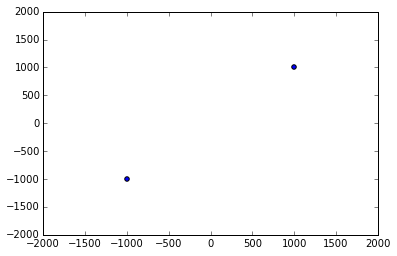

In [61]:
slider = FloatSlider(description='Time', min=0, max=stepN, step=1)

def update_plot():
    time=slider.value
    x = ParticlePositionHistory[:,0,time-1]
    y = ParticlePositionHistory[:,1,time-1]
    fig = plt.figure()
    plt.scatter(x, y)
    plt.xlim(-2000,2000)
    plt.ylim(-2000, 2000)

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()

In [62]:
print gradP()[:,0]/rhoDistribution

distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[ nan  nan]
  [ nan  nan]]]
distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[ nan  nan]
  [ nan  nan]]]
[ 0.  0.]


c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:74: RuntimeWarning: invalid value encountered in true_divide


In [63]:
print gradP()/rhoDistribution[:,np.newaxis]
print gradP().shape
print rhoDistribution.shape

distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[ nan  nan]
  [ nan  nan]]]
distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[ nan  nan]
  [ nan  nan]]]
[[ 0.  0.]
 [ 0.  0.]]
distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[ nan  nan]
  [ nan  nan]]]
distVect: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 R1: 
[[ 0.  0.]
 [ 0.  0.]]

 R12: 
[[    0.          2828.42712475]
 [ 2828.42712475     0.        ]]

 W12: 
[[[ nan  nan]
  [ nan  nan]]

 [[

c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:74: RuntimeWarning: invalid value encountered in true_divide
